<a href="https://colab.research.google.com/github/Darafarm/Darafarm/blob/main/Cell_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, shutil, cv2, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

drive_dataset_path = '/content/drive/MyDrive/cell_images' # Adjust this path if your folder is in a different location on Drive

if os.path.exists(drive_dataset_path):
    print(f"The directory '{drive_dataset_path}' exists on Google Drive.")
else:
    print(f"The directory '{drive_dataset_path}' does NOT exist on Google Drive.")

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from glob import glob

# Path to your downloaded dataset
drive_dataset_path = '/content/drive/MyDrive/cell_images/cell_images/cell_images'

# Target project root
project_root = '/content/drive/MyDrive/cell_project'

# RAW folder inside project
raw_root = os.path.join(project_root, 'RAW')

# Create RAW/train, RAW/val, RAW/test structure
splits = ['train', 'val', 'test']
classes = ['Parasitized', 'Uninfected']

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(raw_root, split, cls), exist_ok=True)

print("Folder structure created successfully.")


In [ ]:
# Load all images from both classes
parasitized_paths = glob(os.path.join(drive_dataset_path, 'Parasitized', '*.png'))
uninfected_paths = glob(os.path.join(drive_dataset_path, 'Uninfected', '*.png'))

print("Parasitized:", len(parasitized_paths))
print("Uninfected:", len(uninfected_paths))


In [ ]:
import pandas as pd

# Create dataframe
df = pd.DataFrame({
    'filepath': parasitized_paths + uninfected_paths,
    'label':     ['Parasitized'] * len(parasitized_paths)
               + ['Uninfected'] * len(uninfected_paths)
})

print(df.head())


NameError: name 'parasitized_paths' is not defined

In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['label'],
    random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


In [ ]:
def copy_files(df, split_name):
    for _, row in df.iterrows():
        src = row['filepath']
        cls = row['label']
        dest = os.path.join(raw_root, split_name, cls, os.path.basename(src))
        shutil.copy(src, dest)

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

print(" RAW dataset successfully split & copied!")


In [ ]:
import os

# Define the paths to check
val_path = os.path.join(raw_root, 'val')
test_path = os.path.join(raw_root, 'test')

print(f"Contents of {val_path}:")
for root, dirs, files in os.walk(val_path):
    # We only need to know if the directories for classes exist and if they contain files
    if dirs:
        print(f"  Subdirectories: {dirs}")
    if files:
        print(f"  Files (first 5): {files[:5]}...")
    if not dirs and not files:
        print("  (Empty)")

print(f"\nContents of {test_path}:")
for root, dirs, files in os.walk(test_path):
    if dirs:
        print(f"  Subdirectories: {dirs}")
    if files:
        print(f"  Files (first 5): {files[:5]}...")
    if not dirs and not files:
        print("  (Empty)")


In [ ]:
import os

# Define the root of your RAW dataset
raw_root = '/content/drive/MyDrive/cell_project/RAW'

print(f"File counts in RAW dataset subfolders (under {raw_root}):")

# Iterate through the main splits (train, val, test)
for split_name in ['train', 'val', 'test']:
    split_path = os.path.join(raw_root, split_name)
    print(f"\n--- {split_name.upper()} ---")

    # Iterate through the classes within each split
    for class_name in ['Parasitized', 'Uninfected']:
        class_path = os.path.join(split_path, class_name)

        if os.path.exists(class_path) and os.path.isdir(class_path):
            num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"  {class_name}: {num_files} files")
        else:
            print(f"  {class_name}: Directory not found or is empty.")

    # Also count total files in the split for a quick check
    total_split_files = 0
    if os.path.exists(split_path):
        for root, _, files in os.walk(split_path):
            total_split_files += len(files)
    print(f"Total files in {split_name.upper()} split: {total_split_files}")


File counts in RAW dataset subfolders (under /content/drive/MyDrive/cell_project/RAW):

--- TRAIN ---
  Parasitized: 9645 files
  Uninfected: 9645 files
Total files in TRAIN split: 19290

--- VAL ---
  Parasitized: 2067 files
  Uninfected: 2067 files
Total files in VAL split: 4134

--- TEST ---
  Parasitized: 2067 files
  Uninfected: 2067 files
Total files in TEST split: 4134


# HISTOGRAM EQUALIZATION


In [ ]:
import cv2
import numpy as np

def manual_hist_eq(img_bgr):
    """
    Apply manual histogram equalization to a BGR image.
    Returns: equalized BGR image.
    """
    # Convert to grayscale
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Compute histogram
    hist, bins = np.histogram(img_gray.flatten(), 256, [0, 256])

    # CDF
    cdf = hist.cumsum()

    # Mask zeros to avoid division by zero
    cdf_masked = np.ma.masked_equal(cdf, 0)

    # Normalize CDF to [0, 255]
    cdf_norm = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())
    cdf_norm = np.ma.filled(cdf_norm, 0).astype('uint8')

    # Apply mapping
    img_eq_gray = cdf_norm[img_gray]

    # Convert back to BGR (3 channels) so CNN can use it like normal RGB
    img_eq_bgr = cv2.cvtColor(img_eq_gray, cv2.COLOR_GRAY2BGR)

    return img_eq_bgr


In [ ]:
import os
import matplotlib.pyplot as plt

dataset_path = "/content/drive/MyDrive/cell_images/cell_images/cell_images"

parasitized_path = os.path.join(dataset_path, "Parasitized")
uninfected_path  = os.path.join(dataset_path, "Uninfected")

# pick 1 sample from each folder
sample_parasitized = os.path.join(parasitized_path, os.listdir(parasitized_path)[1])
sample_uninfected  = os.path.join(uninfected_path, os.listdir(uninfected_path)[1])

img_para = cv2.imread(sample_parasitized)
img_uninf = cv2.imread(sample_uninfected)


In [ ]:
gray_para = cv2.cvtColor(img_para, cv2.COLOR_BGR2GRAY)
he_para = manual_hist_eq(img_para)

gray_uninf = cv2.cvtColor(img_uninf, cv2.COLOR_BGR2GRAY)
he_uninf = manual_hist_eq(img_uninf)

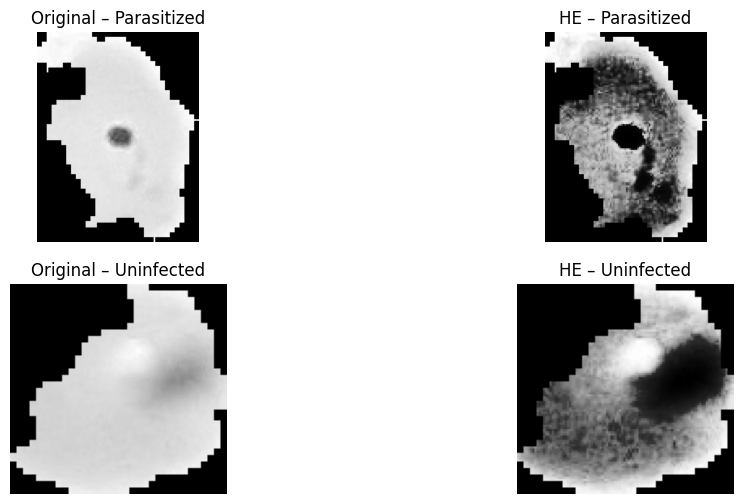

In [ ]:
plt.figure(figsize=(12,6))

# Parasitized
plt.subplot(2,2,1)
plt.imshow(gray_para, cmap='gray')
plt.title("Original – Parasitized")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(he_para, cmap='gray')
plt.title("HE – Parasitized")
plt.axis('off')

# Uninfected
plt.subplot(2,2,3)
plt.imshow(gray_uninf, cmap='gray')
plt.title("Original – Uninfected")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(he_uninf, cmap='gray')
plt.title("HE – Uninfected")
plt.axis('off')

plt.show()


/tmp/ipython-input-1258917522.py:5: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(original.flatten(), 256, [0,256], color='blue')
/tmp/ipython-input-1258917522.py:9: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(equalized.flatten(), 256, [0,256], color='green')


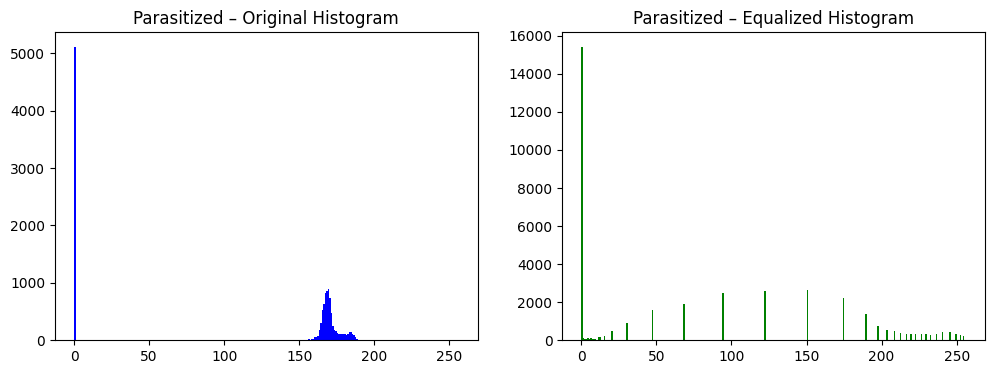

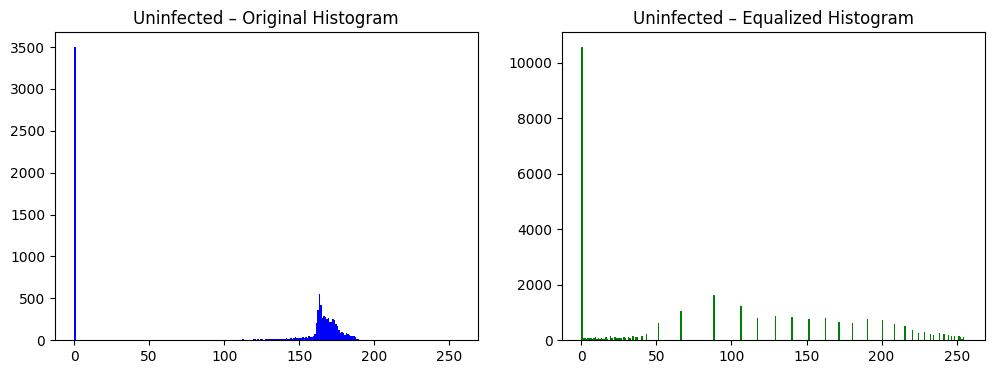

In [ ]:
def plot_histograms(original, equalized, title_prefix):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.hist(original.flatten(), 256, [0,256], color='blue')
    plt.title(f"{title_prefix} – Original Histogram")

    plt.subplot(1,2,2)
    plt.hist(equalized.flatten(), 256, [0,256], color='green')
    plt.title(f"{title_prefix} – Equalized Histogram")

    plt.show()

plot_histograms(gray_para, he_para, "Parasitized")
plot_histograms(gray_uninf, he_uninf, "Uninfected")


In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np
import shutil

base_dir = "/content/drive/MyDrive/cell_project"
raw_dir  = os.path.join(base_dir, "RAW")
he_dir   = os.path.join(base_dir, "HE")

classes = ["Parasitized", "Uninfected"]
splits = ["train", "val", "test"]

# Manual Histogram Equalization Function
def manual_hist_eq(img):

    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # compute histogram
    hist, bins = np.histogram(gray.flatten(), 256, [0, 256])

    # compute CDF
    cdf = hist.cumsum()
    cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
    cdf = cdf.astype('uint8')

    # apply equalization
    img_eq = cdf[gray]

    # convert back to BGR for saving
    img_eq_bgr = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2BGR)

    return img_eq_bgr  # ONLY return the equalized image


#Creating Output Directory Structure
for split in splits:
    for cls in classes:
        out_path = os.path.join(he_dir, split, cls)
        os.makedirs(out_path, exist_ok=True)

print("HE folder structure created.\n")

#Process RAW - HE for all splits/classes
for split in splits:
    print(f"\n=== Processing {split.upper()} ===")

    for cls in classes:

        input_path = os.path.join(raw_dir, split, cls)
        output_path = os.path.join(he_dir, split, cls)

        images = os.listdir(input_path)

        for file in tqdm(images, desc=f"{split}/{cls}"):
            src = os.path.join(input_path, file)
            dst = os.path.join(output_path, file)

            try:
                img = cv2.imread(src)
                if img is None:
                    continue

                img_eq = manual_hist_eq(img)
                cv2.imwrite(dst, img_eq)

            except Exception as e:
                print(f"Error processing {src}: {e}")
                continue

print("\n HE preprocessing completed successfully!")


In [ ]:
import os

# Define the root of your HE dataset
he_root = '/content/drive/MyDrive/cell_project/HE'

print(f"File counts in HE dataset subfolders (under {he_root}):")

# Iterate through the main splits (train, val, test)
for split_name in ['train', 'val', 'test']:
    split_path = os.path.join(he_root, split_name)
    print(f"\n--- {split_name.upper()} ---")

    # Iterate through the classes within each split
    for class_name in ['Parasitized', 'Uninfected']:
        class_path = os.path.join(split_path, class_name)

        if os.path.exists(class_path) and os.path.isdir(class_path):
            num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            print(f"  {class_name}: {num_files} files")
        else:
            print(f"  {class_name}: Directory not found or is empty.")

    # Also count total files in the split for a quick check
    total_split_files = 0
    if os.path.exists(split_path):
        for root, _, files in os.walk(split_path):
            total_split_files += len(files)
    print(f"Total files in {split_name.upper()} split: {total_split_files}")


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Base project path
base_proj_path = "/content/drive/MyDrive/cell_project"

# RAW dataset root (already split)
raw_root = os.path.join(base_proj_path, "RAW")

# Output root for Fourier-filtered images
fourier_root = os.path.join(base_proj_path, "FOURIER_FILTERED")

os.makedirs(fourier_root, exist_ok=True)

splits = ["train", "val", "test"]
classes = ["Parasitized", "Uninfected"]
print("RAW root:", raw_root)
print("FOURIER root:", fourier_root)


RAW root: /content/drive/MyDrive/cell_project/RAW
FOURIER root: /content/drive/MyDrive/cell_project/FOURIER_FILTERED


In [ ]:
def low_pass_mask(shape, cutoff_radius):
    """
    Create a circular low-pass mask of given cutoff_radius.
    shape: (rows, cols) of the grayscale image.
    """
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2  # center

    Y, X = np.ogrid[:rows, :cols]
    dist_from_center = np.sqrt((X - ccol)**2 + (Y - crow)**2)

    mask = np.zeros((rows, cols), np.uint8)
    mask[dist_from_center <= cutoff_radius] = 1
    return mask


def fourier_lowpass_filter(img_bgr, cutoff_radius=30):
    """
    Apply 2D DFT, circular low-pass filtering, inverse DFT.
    Returns:
      - filtered_gray_uint8: filtered image in spatial domain (uint8)
      - mag_spectrum_before: magnitude spectrum before filtering (for visualization)
      - mag_spectrum_after: magnitude spectrum after filtering (for visualization)
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # DFT
    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Magnitude spectrum BEFORE filtering (for visualization)
    mag_before = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
    mag_before = np.log(1 + mag_before)  # log-scaling for visibility

    # Build low-pass mask
    mask = low_pass_mask(gray.shape, cutoff_radius)
    mask_2ch = np.repeat(mask[:, :, np.newaxis], 2, axis=2)  # make it 2-channel

    # Apply mask
    dft_shift_filtered = dft_shift * mask_2ch

    # Magnitude spectrum AFTER filtering
    mag_after = cv2.magnitude(dft_shift_filtered[:,:,0], dft_shift_filtered[:,:,1])
    mag_after = np.log(1 + mag_after)

    # Inverse DFT
    f_ishift = np.fft.ifftshift(dft_shift_filtered)
    img_back_complex = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back_complex[:,:,0], img_back_complex[:,:,1])

    # Normalize to 0–255, uint8
    img_back_norm = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    img_back_uint8 = img_back_norm.astype("uint8")

    return img_back_uint8, mag_before, mag_after


Microscopy cell images contain high-frequency sensor noise and fine artifacts that are not clinically relevant. A circular low-pass filter preserves the global cell structure while suppressing high-frequency noise, helping the CNN focus on larger parasite/non-parasite patterns rather than pixel-level noise.

Sample image: /content/drive/MyDrive/cell_project/RAW/train/Parasitized/C39P4thinF_original_IMG_20150622_113842_cell_38.png


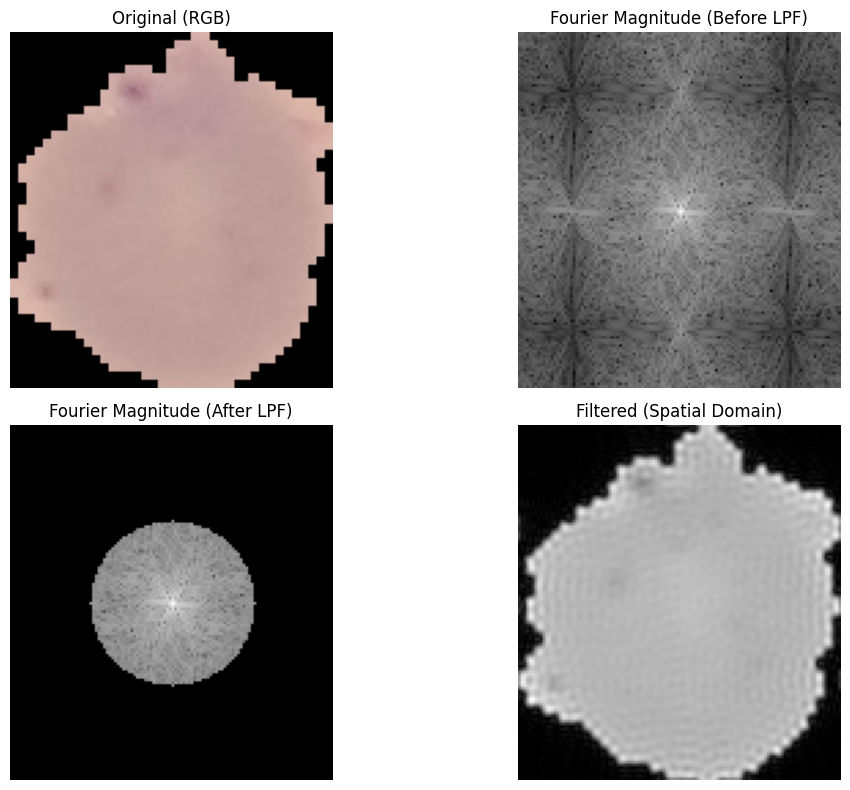

In [ ]:
# Pick one sample image for visualization
sample_path = None
sample_split = "train"
sample_class = "Parasitized"

sample_dir = os.path.join(raw_root, sample_split, sample_class)
for f in os.listdir(sample_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        sample_path = os.path.join(sample_dir, f)
        break

print("Sample image:", sample_path)

# Load and process
sample_img = cv2.imread(sample_path)
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

filtered_gray, mag_before, mag_after = fourier_lowpass_filter(sample_img, cutoff_radius=30)

# Plot original, spectra, filtered
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(sample_img_rgb)
plt.title("Original (RGB)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(mag_before, cmap='gray')
plt.title("Fourier Magnitude (Before LPF)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(mag_after, cmap='gray')
plt.title("Fourier Magnitude (After LPF)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(filtered_gray, cmap='gray')
plt.title("Filtered (Spatial Domain)")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# CONFIG
raw_root = '/content/drive/MyDrive/cell_project/RAW'
fourier_root = '/content/drive/MyDrive/cell_project/FOURIER_FILTERED'

splits = ['train', 'val', 'test']
classes = ['Parasitized', 'Uninfected']

cutoff_radius = 15
# Fourier helper functions
def low_pass_filter(dft_shift, radius):
    rows, cols = dft_shift.shape[:2]
    crow, ccol = rows // 2, cols // 2

    mask = np.zeros((rows, cols, 2), np.uint8)
    Y, X = np.ogrid[:rows, :cols]
    dist = np.sqrt((X - ccol) ** 2 + (Y - crow) ** 2)
    mask[dist <= radius] = 1
    return dft_shift * mask

def fourier_lowpass_gray(img_gray, radius=15):
    # DFT
    dft = cv2.dft(np.float32(img_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Apply low-pass mask
    filtered_shift = low_pass_filter(dft_shift, radius)

    # Inverse DFT
    f_ishift = np.fft.ifftshift(filtered_shift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # Normalize to uint8
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    return img_back.astype('uint8')

# Create output folders
print(f"Saving Fourier-filtered images to: {fourier_root}")

for split in splits:
    for cls in classes:
        out_dir = os.path.join(fourier_root, split, cls)
        os.makedirs(out_dir, exist_ok=True)


# Main splitting processing loop

total_processed = 0
total_errors = 0

for split in splits:
    for cls in classes:
        in_dir = os.path.join(raw_root, split, cls)
        out_dir = os.path.join(fourier_root, split, cls)

        if not os.path.exists(in_dir):
            print(f"Input folder not found: {in_dir}")
            continue

        files = [f for f in os.listdir(in_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print(f"\nProcessing {split}/{cls}: {len(files)} images")

        for fname in tqdm(files, desc=f"{split}/{cls}", leave=False):
            try:
                in_path = os.path.join(in_dir, fname)
                out_path = os.path.join(out_dir, fname)

                img_gray = cv2.imread(in_path, cv2.IMREAD_GRAYSCALE)
                if img_gray is None:
                    print(f" Could not read {in_path}, skipping.")
                    total_errors += 1
                    continue

                filtered = fourier_lowpass_gray(img_gray, radius=cutoff_radius)

                ok = cv2.imwrite(out_path, filtered)
                if not ok:
                    print(f"Failed to save {out_path}")
                    total_errors += 1
                else:
                    total_processed += 1

            except Exception as e:
                print(f"   Error on {in_path}: {e}")
                total_errors += 1

print("\n Fourier preprocessing completed.")
print(f"Total processed images: {total_processed}")
print(f"Total errors: {total_errors}")
print(f"Output root: {fourier_root}")


Saving Fourier-filtered images to: /content/drive/MyDrive/cell_project/FOURIER_FILTERED

Processing train/Parasitized: 9645 images



Processing train/Uninfected: 9645 images


train/Uninfected:  88%|████████▊ | 8534/9645 [37:58<07:36,  2.43it/s]

 Could not read /content/drive/MyDrive/cell_project/RAW/train/Uninfected/C237ThinF_IMG_20151127_104844_cell_222.png, skipping.



Processing val/Parasitized: 2067 images



Processing val/Uninfected: 2067 images



Processing test/Parasitized: 2067 images



Processing test/Uninfected: 2067 images



 Fourier preprocessing completed.
Total processed images: 27557
Total errors: 1
Output root: /content/drive/MyDrive/cell_project/FOURIER_FILTERED


Model training


In [ ]:
import os

root = "/content/drive/MyDrive/cell_project"

for dirpath, dirnames, filenames in os.walk(root):
    print(dirpath, "-->", len(filenames), "files")


In [ ]:
print(train_gen.class_indices)
print(len(train_gen))
batch = next(train_gen)
print(batch[0].shape, batch[1][:10])


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow version:", tf.__version__)

# PATHS
BASE_DIR = "/content/drive/MyDrive/cell_project"
RAW_DIR  = os.path.join(BASE_DIR, "RAW")

train_dir = os.path.join(RAW_DIR, "train")
val_dir   = os.path.join(RAW_DIR, "val")
test_dir  = os.path.join(RAW_DIR, "test")

print("Train dir:", train_dir)
print("Val dir:  ", val_dir)
print("Test dir: ", test_dir)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32


In [ ]:
# Augmentation for training, only rescale for val/test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


In [ ]:
import matplotlib.pyplot as plt

batch_imgs, batch_labels = next(train_gen)
print("Batch shape:", batch_imgs.shape)
print("First 10 labels:", batch_labels[:10])

plt.imshow(batch_imgs[0])
plt.title(f"Label: {batch_labels[0]}")
plt.axis("off")
plt.show()


In [ ]:
def build_simple_cnn(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )
    return model

model = build_simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = os.path.join(BASE_DIR, "best_raw_cnn.keras")

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1)
]

EPOCHS = 15

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/cell_project/best_raw_cnn.keras")
test_loss, test_acc, test_auc, test_prec, test_recall = model.evaluate(test_gen)
print(test_loss, test_acc, test_auc, test_prec, test_recall)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

def build_cnn(input_shape=(224,224,3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )
    return model


In [ ]:
he_path = "/content/drive/MyDrive/cell_project/HE"

datagen = ImageDataGenerator(rescale=1/255.)

train_gen = datagen.flow_from_directory(
    os.path.join(he_path, "train"),
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

val_gen = datagen.flow_from_directory(
    os.path.join(he_path, "val"),
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

test_gen = datagen.flow_from_directory(
    os.path.join(he_path, "test"),
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)

In [ ]:
checkpoint_path = "/content/drive/MyDrive/cell_project/best_he_cnn.keras"

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", mode="min"),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
]


In [ ]:
model_he = build_cnn()

history_he = model_he.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/cell_project/best_he_cnn.keras")
test_loss, test_acc, test_auc, test_prec, test_recall = model.evaluate(test_gen)
print(test_loss, test_acc, test_auc, test_prec, test_recall)



In [ ]:
from PIL import Image
import os
from tqdm import tqdm

def remove_corrupted_images(root_path):
    removed = 0
    checked = 0

    print(f"\n Scanning for corrupted images in:\n{root_path}\n")

    for subdir, _, files in os.walk(root_path):
        for file in tqdm(files, desc=subdir):
            filepath = os.path.join(subdir, file)
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            checked += 1
            try:
                img = Image.open(filepath)
                img.verify()  # detect corruption
            except Exception:
                print(f" Corrupted: {filepath}")
                removed += 1
                os.remove(filepath)  # delete it

    print(f"\n Done scanning {root_path}")
    print(f"  Checked: {checked}")
    print(f"  Removed corrupted: {removed}\n")


# RUN FOR ALL DATASETS
remove_corrupted_images("/content/drive/MyDrive/cell_project/RAW")
remove_corrupted_images("/content/drive/MyDrive/cell_project/HE")
remove_corrupted_images("/content/drive/MyDrive/cell_project/FOURIER_FILTERED")


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/cell_project/best_he_cnn.keras")
test_loss, test_acc, test_auc, test_prec, test_recall = model.evaluate(test_gen)
print(test_loss, test_acc, test_auc, test_prec, test_recall)

In [ ]:
fourier_root = "/content/drive/MyDrive/cell_project/FOURIER_FILTERED"


In [ ]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(fourier_root, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(fourier_root, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(fourier_root, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 19290 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


In [ ]:
def build_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(224,224,3)),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc"),
                 tf.keras.metrics.Precision(name="precision"),
                 tf.keras.metrics.Recall(name="recall")]
    )
    return model

model = build_cnn_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/MyDrive/cell_project/best_fourier_cnn.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


In [ ]:
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 7577s 13s/step - accuracy: 0.5473 - auc: 0.5671 - loss: 0.6869 - precision: 0.5418 - recall: 0.5515 - val_accuracy: 0.6280 - val_auc: 0.6832 - val_loss: 0.6473 - val_precision: 0.6297 - val_recall: 0.6212 - learning_rate: 1.0000e-04
Epoch 2/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 2521s 4s/step - accuracy: 0.6464 - auc: 0.6995 - loss: 0.6311 - precision: 0.6691 - recall: 0.5818 - val_accuracy: 0.7383 - val_auc: 0.8232 - val_loss: 0.5364 - val_precision: 0.7240 - val_recall: 0.7702 - learning_rate: 1.0000e-04
Epoch 3/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 2511s 4s/step - accuracy: 0.7383 - auc: 0.8215 - loss: 0.5262 - precision: 0.7516 - recall: 0.7126 - val_accuracy: 0.7866 - val_auc: 0.9095 - val_loss: 0.4514 - val_precision: 0.7215 - val_recall: 0.9337 - learning_rate: 1.0000e-04
Epoch 4/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 2515s 4s/step - accuracy: 0.8250 - auc: 0.9005 - loss: 0.4165 - precision: 0.8137 - recall: 0.8475 - val_accuracy: 0.8788 - val_auc: 0.9466 - v

In [ ]:
test_loss, test_acc, test_auc, test_prec, test_recall = model.evaluate(test_gen)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)
print("Test Precision:", test_prec)
print("Test Recall:", test_recall)


In [ ]:
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Parasitized","Uninfected"],
            yticklabels=["Parasitized","Uninfected"])
plt.title("CONFUSION MATRIX (FOURIER)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred))
